https://blog.csdn.net/Q_M_X_D_D_/article/details/109366895

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np
import math

# 导入数据

In [ ]:
data=pd.read_excel("cpss_v2.xlsx")
data

,Date,cn,wd,a,b,1t,2t,3t,4t,5t,6t,7mt
0,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1
1,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2
2,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4
3,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2
4,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
354,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3
355,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
356,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
357,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1


In [ ]:
data=data[['Date','a']]
data

,Date,a
0,2022-01-07,80630
1,2022-01-08,101503
2,2022-01-09,91477
3,2022-01-10,107134
4,2022-01-11,153880
...,...,...
354,2022-12-27,20879
355,2022-12-28,20160
356,2022-12-29,20001
357,2022-12-30,21204


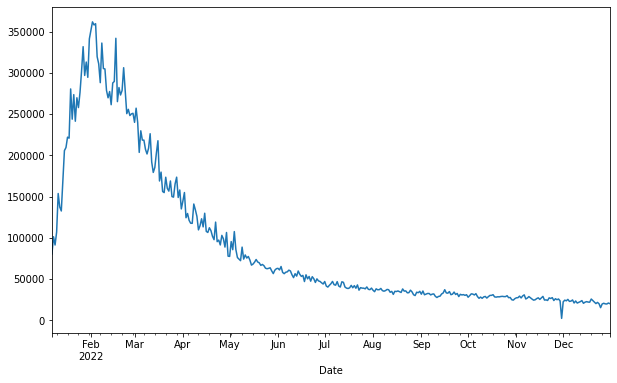

In [ ]:
# 时间与Number of reported results折线图
series = data.set_index(['Date'], drop=True)# 原始数据
plt.figure(figsize=(10, 6))
 
series['a'].plot()

plt.show()

# 构建数据集

In [ ]:
# DataFrame格式转换为二维数组，再进行数据差分
def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)
 
# 这里的series是之前数据预处理后得到的DateFrame型数据
raw_value=series.values
diff_value=difference(raw_value,1)
diff_value # 差分值

0       [20873]
1      [-10026]
2       [15657]
3       [46746]
4      [-16294]
         ...   
353       [868]
354      [-719]
355      [-159]
356      [1203]
357      [-824]
Length: 358, dtype: object

In [ ]:
# 时间序列转化为监督学习集：两两一组 前一个差分是输入 后一个差分是输出
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(1)]
    columns.append(df)
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df
 
supervised=timeseries_to_supervised(diff_value,1)
supervised_value=supervised.values
supervised_value

array([[0, array([20873])],
       [array([20873]), array([-10026])],
       [array([-10026]), array([15657])],
       [array([15657]), array([46746])],
       [array([46746]), array([-16294])],
       [array([-16294]), array([-4860])],
       [array([-4860]), array([36758])],
       [array([36758]), array([36396])],
       [array([36396]), array([3729])],
       [array([3729]), array([12588])],
       [array([12588]), array([-1247])],
       [array([-1247]), array([59672])],
       [array([59672]), array([-36658])],
       [array([-36658]), array([29763])],
       [array([29763]), array([-32238])],
       [array([-32238]), array([28440])],
       [array([28440]), array([-11891])],
       [array([-11891]), array([18366])],
       [array([18366]), array([25944])],
       [array([25944]), array([29496])],
       [array([29496]), array([-34876])],
       [array([-34876]), array([16252])],
       [array([16252]), array([-18533])],
       [array([-18533]), array([46627])],
       [array([46

In [ ]:
# 7:3切分训练集与测试集
testNum=108
train,test=supervised_value[:-testNum],supervised_value[-testNum:]

In [ ]:
#train

In [ ]:
#test

In [ ]:
# 正则化于-1,1
def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled
 
scaler,train_scaled,test_scaled=scale(train,test)
print('train_scaled',train_scaled)
print('test_scaled',test_scaled)

train_scaled [[ 0.12528127  0.43125399]
 [ 0.43125399 -0.02168767]
 [-0.02168767  0.35479379]
 [ 0.35479379  0.81052061]
 [ 0.81052061 -0.1135689 ]
 [-0.1135689   0.05403959]
 [ 0.05403959  0.66410871]
 [ 0.66410871  0.65880223]
 [ 0.65880223  0.17994386]
 [ 0.17994386  0.30980599]
 [ 0.30980599  0.10700177]
 [ 0.10700177  1.        ]
 [ 1.         -0.4120803 ]
 [-0.4120803   0.56157054]
 [ 0.56157054 -0.34728849]
 [-0.34728849  0.54217698]
 [ 0.54217698 -0.04902629]
 [-0.04902629  0.39450442]
 [ 0.39450442  0.50558866]
 [ 0.50558866  0.55765665]
 [ 0.55765665 -0.38595835]
 [-0.38595835  0.36351576]
 [ 0.36351576 -0.14638991]
 [-0.14638991  0.80877621]
 [ 0.80877621  0.27698498]
 [ 0.27698498  0.27546047]
 [ 0.27546047  0.0705747 ]
 [ 0.0705747   0.14731341]
 [ 0.14731341 -0.46079143]
 [-0.46079143 -0.00195695]
 [-0.00195695 -0.20879234]
 [-0.20879234  0.82901999]
 [ 0.82901999 -0.32714733]
 [-0.32714733  0.11733621]
 [ 0.11733621 -0.25590566]
 [-0.25590566 -0.00578289]
 [-0.00578289  

# 训练LSTM模型

In [ ]:
# 将训练集中的输入和输出两列分为x和y，并将输入列转换为三维数组
# X,y=train[:,0:-1],train[:,-1]
X,y=train_scaled[:,0:-1],train_scaled[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
X

array([[[ 0.12528127]],

       [[ 0.43125399]],

       [[-0.02168767]],

       [[ 0.35479379]],

       [[ 0.81052061]],

       [[-0.1135689 ]],

       [[ 0.05403959]],

       [[ 0.66410871]],

       [[ 0.65880223]],

       [[ 0.17994386]],

       [[ 0.30980599]],

       [[ 0.10700177]],

       [[ 1.        ]],

       [[-0.4120803 ]],

       [[ 0.56157054]],

       [[-0.34728849]],

       [[ 0.54217698]],

       [[-0.04902629]],

       [[ 0.39450442]],

       [[ 0.50558866]],

       [[ 0.55765665]],

       [[-0.38595835]],

       [[ 0.36351576]],

       [[-0.14638991]],

       [[ 0.80877621]],

       [[ 0.27698498]],

       [[ 0.27546047]],

       [[ 0.0705747 ]],

       [[ 0.14731341]],

       [[-0.46079143]],

       [[-0.00195695]],

       [[-0.20879234]],

       [[ 0.82901999]],

       [[-0.32714733]],

       [[ 0.11733621]],

       [[-0.25590566]],

       [[-0.00578289]],

       [[ 0.23648277]],

       [[-0.10852628]],

       [[ 0.51102707]],



In [ ]:
# 初始化LSTM模型并开始训练，设置神经元核心的个数，设置训练时输入数据的格式等等
def fit_lstm(train,batch_size,nb_epoch,neurons):
    # 将数据对中的x和y分开
    X,y=train[:,0:-1],train[:,-1]
    # 将2D数据拼接成3D数据，形状为[N*1*1]
    X=X.reshape(X.shape[0],1,X.shape[1])
 
    model=Sequential()
    model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(1))
 
    model.compile(loss='mean_squared_error',optimizer='adam')
    for i in range(nb_epoch):
        # shuffle是不混淆数据顺序
        his=model.fit(X,y,batch_size=batch_size,verbose=1,shuffle=False)
        # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
        model.reset_states()
    return model
 
# 构建一个LSTM模型并训练，batch_size为1，训练次数为3，LSTM层神经元个数为4       
lstm_model=fit_lstm(train_scaled,1,3,4)

250/250 [==============================] - 0s 2ms/step - loss: 0.0492


# 模型的泛化

In [ ]:
# 将一条数据的输入和输出列分开，并且将输入进行变换，传入到预测函数中进行单步预测
def forecast_lstm(model,batch_size,X):
    # 将形状为[1:]的，包含一个元素的一维数组X，转换形状为[1,1,1]的3D张量
    print(type(X))
    X=X.reshape(1,1,len(X))
    X=X.astype(np.float32)
    
    # 输出形状为1行一列的二维数组yhat
    yhat=model.predict(X,batch_size=batch_size)
    # 将yhat中的结果返回
    return yhat[0,0]

# 得到预测值后对其进行逆缩放和逆差分，将其还原到原来的取值范围内
# 对预测的数据进行逆差分转换
def invert_difference(history,yhat,interval=1):
    return yhat+history[-interval]
 
# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler,X,y):
    # 将X,y转换为一个list列表
    new_row=[x for x in X]+[y]
    # 将列表转换为数组
    array=np.array(new_row)
    # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
    array=array.reshape(1,len(array))
    # 逆缩放输入的形状为[1,2]，输出形状也是如此
    invert=scaler.inverse_transform(array)
    # 只需要返回y值即可
    return invert[0,-1]

# 遍历全部测试集数据，对每行数据执行以上操作，并将最终的预测值保存下来
predictions=list()
for i in range(len(test_scaled)):
    # 将测试集拆分为X和y
    # X,y=test[i,0:-1],test[i,-1]
    X,y=test_scaled[i,0:-1],test[i,-1]
    print('X',X)
    # 将训练好的模型、测试数据传入预测函数中
    yhat=forecast_lstm(lstm_model,1,X)
    # 将预测值进行逆缩放
    yhat=invert_scale(scaler,X,yhat)
    # 对预测的y值进行逆差分
    print('yhat前',yhat)
    yhat=invert_difference(raw_value,yhat,len(test_scaled)+1-i)
    print('yhat后来',yhat)
    print('len(test_scaled)+1-i',len(test_scaled)+1-i)
    
    # 存储正在预测的y值
    predictions.append(yhat)


X [0.16405374]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 320ms/step
yhat前 -5587.688741553574
yhat后来 [26554.31125845]
len(test_scaled)+1-i 109
X [0.14290112]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 17ms/step
yhat前 -5006.839703213423
yhat后来 [28337.16029679]
len(test_scaled)+1-i 108
X [0.18340333]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 17ms/step
yhat前 -4869.281697027384
yhat后来 [32439.71830297]
len(test_scaled)+1-i 107
X [0.06824395]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 17ms/step
yhat前 -3354.0272033922365
yhat后来 [30063.97279661]
len(test_scaled)+1-i 106
X [0.12064909]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 19ms/step
yhat前 -2862.9066810421637
yhat后来 [30239.09331896]
len(test_scaled)+1-i 105
X [0.15383657]
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 19ms/step
yhat前 -2813.2901225537053
yhat后来 [32236.70987745]
len(test_scaled)+1-i 104
X [0.0

In [ ]:
predictions

[array([26554.31125845]),
 array([28337.16029679]),
 array([32439.71830297]),
 array([30063.97279661]),
 array([30239.09331896]),
 array([32236.70987745]),
 array([29508.65689182]),
 array([30201.96429658]),
 array([32455.73371617]),
 array([30296.3741387]),
 array([31419.59924324]),
 array([28387.68635887]),
 array([30555.27806237]),
 array([30064.29550546]),
 array([30434.06881818]),
 array([29770.92362723]),
 array([30408.75415225]),
 array([27932.53856666]),
 array([29386.61086949]),
 array([31274.42183059]),
 array([31215.60294733]),
 array([30412.33599637]),
 array([31751.81585597]),
 array([28910.85465836]),
 array([26981.84149908]),
 array([28019.35493642]),
 array([26681.52576996]),
 array([27996.87588721]),
 array([28512.52827842]),
 array([26932.64563782]),
 array([28296.66013458]),
 array([29609.64800987]),
 array([29788.56232306]),
 array([30562.66847698]),
 array([28432.46835655]),
 array([28093.82106405]),
 array([28360.88773008]),
 array([28246.65833973]),
 array([28603

In [ ]:
raw_value[-testNum:]

array([[33344],
       [37309],
       [33418],
       [33102],
       [35050],
       [31277],
       [31976],
       [34455],
       [31509],
       [32777],
       [28994],
       [31706],
       [30985],
       [31355],
       [30477],
       [31223],
       [28202],
       [30088],
       [32288],
       [32014],
       [30935],
       [32522],
       [29026],
       [26905],
       [28408],
       [26878],
       [28575],
       [29151],
       [27197],
       [28906],
       [30403],
       [30459],
       [31269],
       [28612],
       [28322],
       [28741],
       [28637],
       [29084],
       [29279],
       [28947],
       [28953],
       [30063],
       [27609],
       [27905],
       [25156],
       [24672],
       [26498],
       [27502],
       [27670],
       [29554],
       [27330],
       [29743],
       [31068],
       [26096],
       [27213],
       [28984],
       [27467],
       [25993],
       [24660],
       [25085],
       [26536],
       [27475],
       [

# 预测结果的可视化

Test RMSE: 11607635.888778232
Mean: 0.051215546476497335


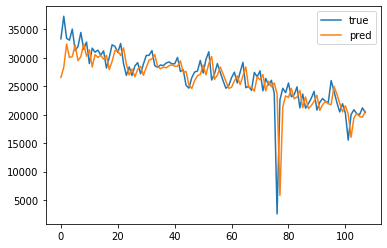

In [ ]:
# 将测试集的y值和预测值绘制在同一张图表中
# 计算方差
rmse=mean_squared_error(raw_value[-testNum:],predictions)
print("Test RMSE:",rmse)
# 计算相对误差
erro=(predictions-raw_value[-testNum:])/raw_value[-testNum:]
# print("Erro:",erro)
Mean=np.mean(erro)
print("Mean:",Mean)
plt.plot(raw_value[-testNum:])
plt.plot(predictions)
plt.legend(['true','pred'])
plt.show()

# 推理

In [ ]:
'''
# 推理一个
scaler=MinMaxScaler(feature_range=(-1,1))
scaler=scaler.fit(train)
test_scaled=scaler.transform([[1203,-824]])
print(test_scaled)# 归一化
# 将训练好的模型、测试数据传入预测函数中
yhat=forecast_lstm(lstm_model,1,np.array([test_scaled[0][1]]))
# 将预测值进行逆缩放
yhat=invert_scale(scaler,np.array([test_scaled[0][1]]),yhat)
# 对预测的y值进行逆差分
yhat=yhat+20380
print('yhat后',yhat)

'''


"\n# 推理一个\nscaler=MinMaxScaler(feature_range=(-1,1))\nscaler=scaler.fit(train)\ntest_scaled=scaler.transform([[1203,-824]])\nprint(test_scaled)# 归一化\n# 将训练好的模型、测试数据传入预测函数中\nyhat=forecast_lstm(lstm_model,1,np.array([test_scaled[0][1]]))\n# 将预测值进行逆缩放\nyhat=invert_scale(scaler,np.array([test_scaled[0][1]]),yhat)\n# 对预测的y值进行逆差分\nyhat=yhat+20380\nprint('yhat后',yhat)\n\n"

In [ ]:
# 60天 到2023 3月1
chafenbiao=[[1203,-824]]# 第一组差分
results=[20380]# 第一个结果
# 归一化
scaler=MinMaxScaler(feature_range=(-1,1))
scaler=scaler.fit(train)

for i in range(59):
    print('i=',i)
    # 测试数据归一化
    test_scaled=scaler.transform([chafenbiao[i]])
    print('test_scaled',test_scaled)
    X=test_scaled[0][1]
    print('X',X)
    # 预测
    yhat=forecast_lstm(lstm_model,1,np.array([X]))
    # 逆缩放
    yhatnsf=invert_scale(scaler,np.array([X]),yhat)
    yhatnsf=int(yhatnsf)
    # 逆差分
    yhatncf=yhatnsf+results[i]
    print('yhat逆缩放+上一个结果',yhatnsf, results[i])
    print('预测结果即为yhat逆差分', yhatncf)
    # 存储结果(更新差分表及结果值)
    results.append(yhatncf)
    print('结果列表',results)
    cur_chafen=yhatncf-results[i]
    chafenbiao.append([chafenbiao[i][1],cur_chafen])
    print('差分表',chafenbiao)

i= 0
test_scaled [[0.14291578 0.11320243]]
X 0.11320243042576426
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 23ms/step
yhat逆缩放+上一个结果 -420 20380
预测结果即为yhat逆差分 19960
结果列表 [20380, 19960]
差分表 [[1203, -824], [-824, -420]]
i= 1
test_scaled [[0.11320243 0.11912458]]
X 0.11912457764389424
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 24ms/step
yhat逆缩放+上一个结果 -355 19960
预测结果即为yhat逆差分 19605
结果列表 [20380, 19960, 19605]
差分表 [[1203, -824], [-824, -420], [-420, -355]]
i= 2
test_scaled [[0.11912458 0.1200774 ]]
X 0.12007739835968248
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 17ms/step
yhat逆缩放+上一个结果 -329 19605
预测结果即为yhat逆差分 19276
结果列表 [20380, 19960, 19605, 19276]
差分表 [[1203, -824], [-824, -420], [-420, -355], [-355, -329]]
i= 3
test_scaled [[0.1200774  0.12045853]]
X 0.12045852664599777
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 19ms/step
yhat逆缩放+上一个结果 -318 19276
预测结果即为yhat逆差分 18958
结果列表 [20380, 19960, 19605, 19276, 

In [ ]:
# 预测区间
'''
a=results[-1]+(results[-1]*Mean)
b=results[-1]-(results[-1]*Mean)
print('预测区间为：', b,a)


预测区间为： 1313.1176836765276 1454.8823163234724
